In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#columns = model_name,personality_1,personality_2,agent_1_scores,agent_2_scores,agent_1_messages,agent_2_messages,agent_1_actions,agent_2_actions,total_rounds
csv_path = "/cluster/home/mlindner/Github/master_thesis_project/src/data/outputs/experiment_250225_solved_1.csv"
df = pd.read_csv(csv_path, converters={
    'agent_1_scores': lambda x: list(map(int, x.strip('[]').split(','))),
    'agent_2_scores': lambda x: list(map(int, x.strip('[]').split(','))),
    'total_rounds': int
})

df['agent_1_cumulative_scores'] = df['agent_1_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))
df['agent_2_cumulative_scores'] = df['agent_2_scores'].apply(lambda x: [0] + list(pd.Series(x).cumsum()))

# Calculate the average cost per round for each row
df['cost_per_round'] = df['total_cost_USD'] / df['total_rounds']

## projected cost

In [4]:
# Calculate the average cost per round across all rows
average_cost_per_round = df['cost_per_round'].mean()

# Calculate the predicted cost
predicted_cost = average_cost_per_round * 7 * 19 * 19 #all types with all types  with 10 rounds
actual_cost = df['total_cost_USD'].sum()
print(f"Predicted Cost: {predicted_cost}")
print(f"Actual Cost: {actual_cost}")

Predicted Cost: 1.9198819799999796
Actual Cost: 1.0104641999999893


## plot the final scores of each agent of each game

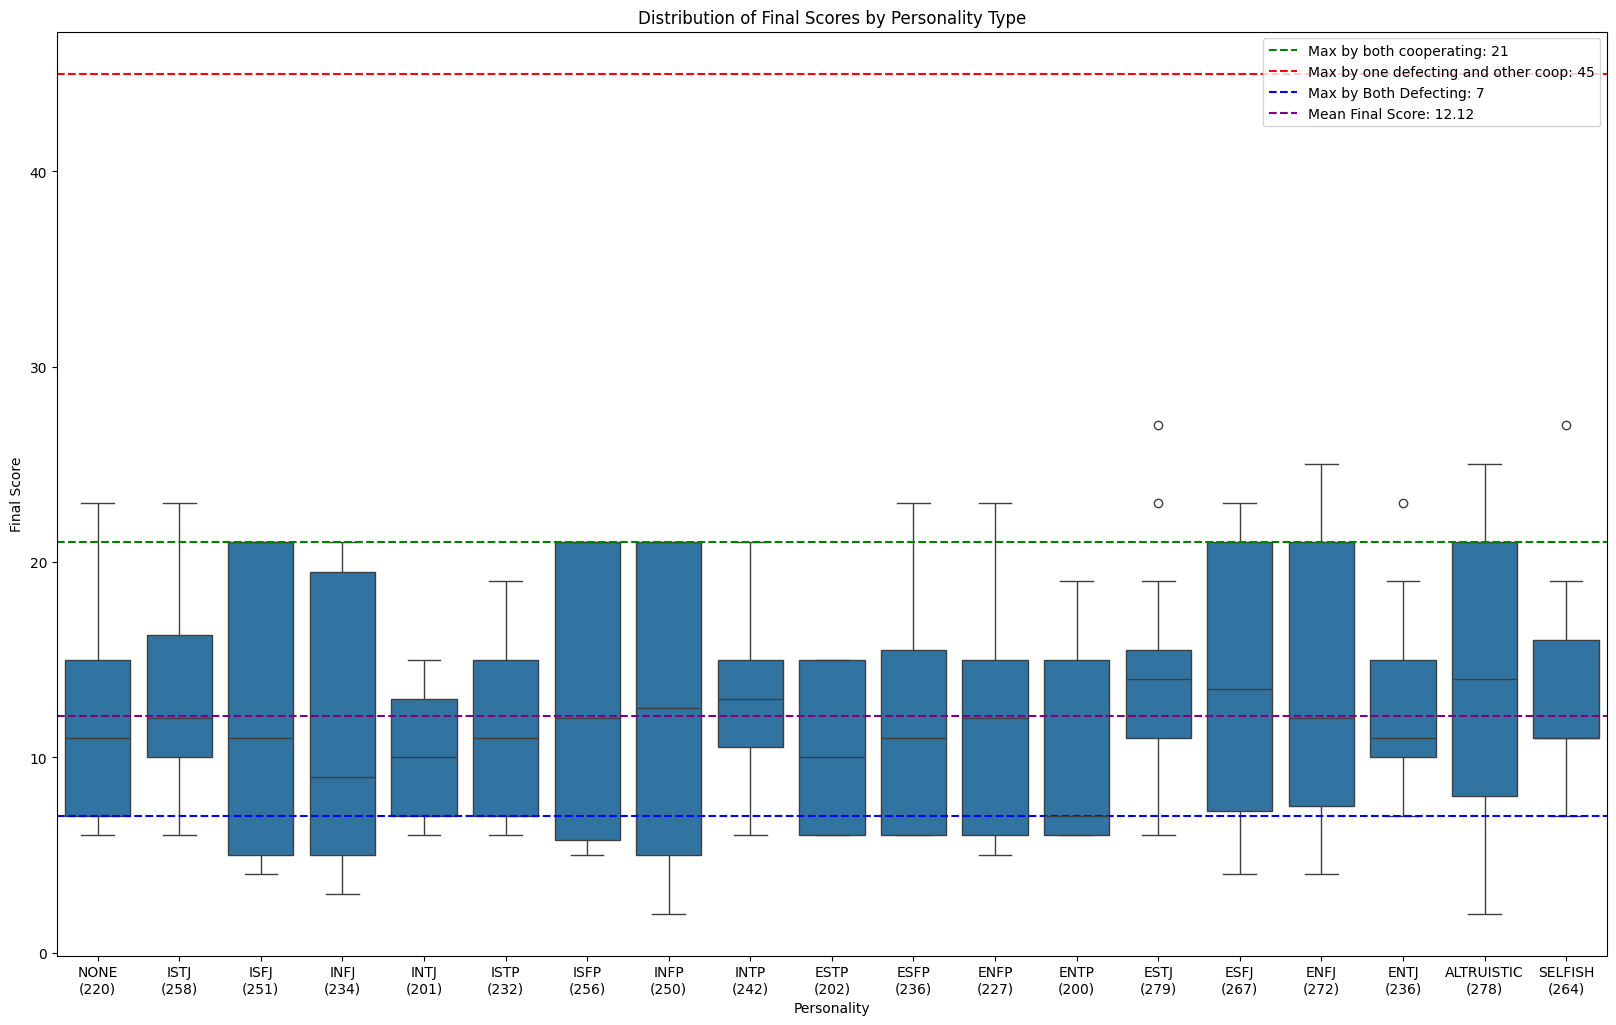

/tmp/ipykernel_3412369/2344638581.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=final_scores_df, x='Personality', y='Final Score', inner='quartile', palette='Set3')


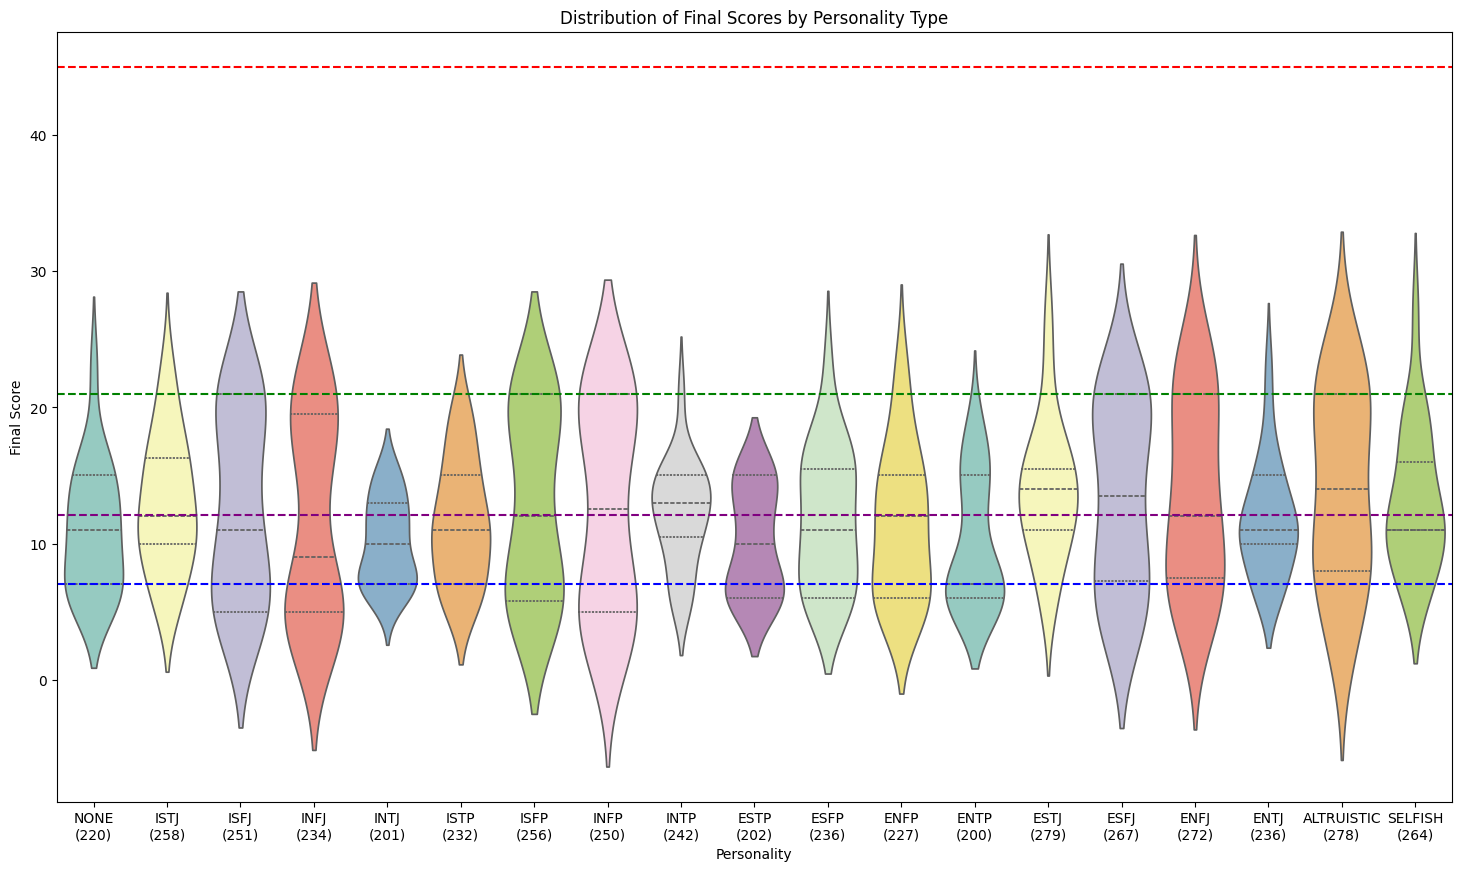

In [5]:
# Extract the final scores and personality types
final_scores = []
for i, row in df.iterrows():
    final_scores.append({'Personality': row['personality_1'], 'Final Score': row['agent_1_cumulative_scores'][-1]})
    final_scores.append({'Personality': row['personality_2'], 'Final Score': row['agent_2_cumulative_scores'][-1]})

# Create a DataFrame from the final scores
final_scores_df = pd.DataFrame(final_scores)
mean_final_score = final_scores_df['Final Score'].mean()

# Calculate total scores across all games for each personality
total_scores = final_scores_df.groupby('Personality')['Final Score'].sum().reset_index()
total_scores_dict = total_scores.set_index('Personality')['Final Score'].to_dict()

# Plot the distribution of final scores by personality type using box plot
plt.figure(figsize=(20, 12))
sns.boxplot(data=final_scores_df, x='Personality', y='Final Score')
plt.axhline(y=21, color='g', linestyle='--', label='Max by both cooperating: 21')
plt.axhline(y=45, color='r', linestyle='--', label='Max by one defecting and other coop: 45')
plt.axhline(y=7, color='b', linestyle='--', label='Max by Both Defecting: 7')
plt.axhline(y=mean_final_score, color='purple', linestyle='--', label=f'Mean Final Score: {mean_final_score:.2f}')
plt.legend()
plt.title('Distribution of Final Scores by Personality Type')

# Add total scores as x-tick labels
xticks_labels = [f"{personality}\n({total_scores_dict[personality]})" for personality in final_scores_df['Personality'].unique()]
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels)

plt.xlabel('Personality')
plt.ylabel('Final Score')
plt.show()

# Plot the distribution of final scores by personality type using violin plot
plt.figure(figsize=(18, 10))
sns.violinplot(data=final_scores_df, x='Personality', y='Final Score', inner='quartile', palette='Set3')
plt.title('Distribution of Final Scores by Personality Type')

# Add total scores as x-tick labels
xticks_labels = [f"{personality}\n({total_scores_dict[personality]})" for personality in final_scores_df['Personality'].unique()]
plt.xticks(ticks=range(len(xticks_labels)), labels=xticks_labels)

#add lines
plt.axhline(y=21, color='g', linestyle='--', label='Max by both cooperating: 21')
plt.axhline(y=45, color='r', linestyle='--', label='Max by one defecting and other coop: 45')
plt.axhline(y=7, color='b', linestyle='--', label='Max by Both Defecting: 7')
plt.axhline(y=mean_final_score, color='purple', linestyle='--', label=f'Mean Final Score: {mean_final_score:.2f}')

plt.xlabel('Personality')
plt.ylabel('Final Score')
plt.show()

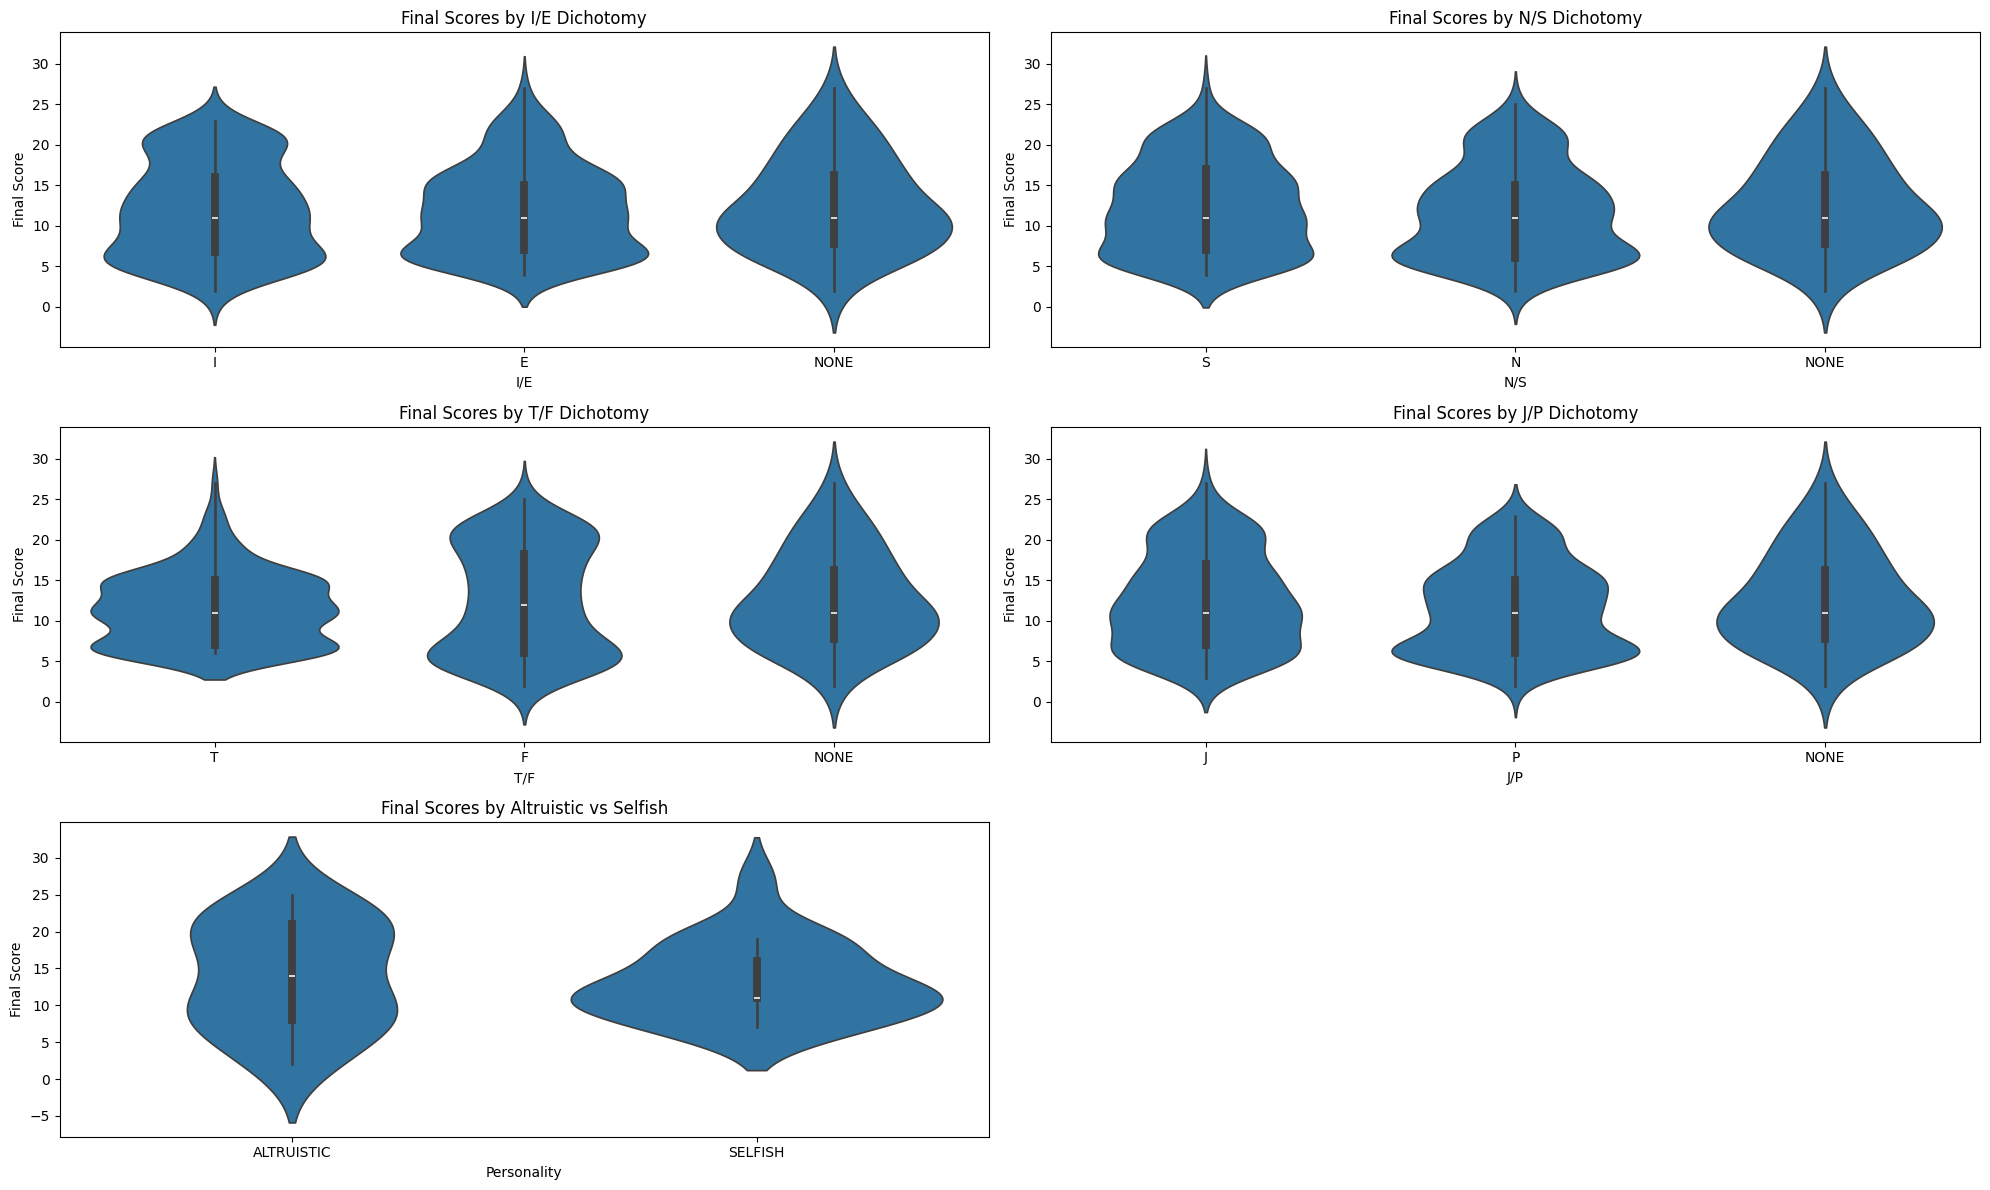

In [6]:
# Filter out the control groups
filtered_df = final_scores_df[~final_scores_df['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])]

# Create a new DataFrame to store the dichotomies
dichotomies_df = pd.DataFrame()

# Map each personality to its dichotomies
dichotomies_df['I/E'] = filtered_df['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E')
dichotomies_df['N/S'] = filtered_df['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S')
dichotomies_df['T/F'] = filtered_df['Personality'].apply(lambda x: 'T' if x[2] == 'T' else 'F')
dichotomies_df['J/P'] = filtered_df['Personality'].apply(lambda x: 'J' if x[3] == 'J' else 'P')
dichotomies_df['Final Score'] = filtered_df['Final Score']

# Add NONE, ALTRUISTIC, and SELFISH to the dichotomies DataFrame
control_df = final_scores_df[final_scores_df['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])].copy()
control_df['I/E'] = 'NONE'
control_df['N/S'] = 'NONE'
control_df['T/F'] = 'NONE'
control_df['J/P'] = 'NONE'
dichotomies_df = pd.concat([dichotomies_df, control_df])

# Plot the boxplots for each dichotomy
plt.figure(figsize=(20, 12))

plt.subplot(3, 2, 1)
sns.violinplot(data=dichotomies_df, x='I/E', y='Final Score')
plt.title('Final Scores by I/E Dichotomy')

plt.subplot(3, 2, 2)
sns.violinplot(data=dichotomies_df, x='N/S', y='Final Score')
plt.title('Final Scores by N/S Dichotomy')

plt.subplot(3, 2, 3)
sns.violinplot(data=dichotomies_df, x='T/F', y='Final Score')
plt.title('Final Scores by T/F Dichotomy')

plt.subplot(3, 2, 4)
sns.violinplot(data=dichotomies_df, x='J/P', y='Final Score')
plt.title('Final Scores by J/P Dichotomy')

plt.subplot(3, 2, 5)
sns.violinplot(data=final_scores_df[final_scores_df['Personality'].isin(['ALTRUISTIC', 'SELFISH'])], x='Personality', y='Final Score')
plt.title('Final Scores by Altruistic vs Selfish')

plt.tight_layout()
plt.show()

In [7]:
#import pygwalk and use dichotomies_df to create a gwalk object
#import pygwalker as pyg
#walker = pyg.walk(dichotomies_df)


## plot mean cummulative scores

Personality: NONE, Mean Cumulative Scores: [0.0, 2.9, 5.2, 6.8, 8.0, 9.0, 10.0, 11.0]
Personality: ISTJ, Mean Cumulative Scores: [0.0, 2.75, 5.1, 6.95, 8.95, 10.35, 11.7, 12.9]
Personality: ISFJ, Mean Cumulative Scores: [0.0, 2.1, 4.05, 5.8, 7.6, 9.5, 11.1, 12.55]
Personality: INFJ, Mean Cumulative Scores: [0.0, 1.5, 3.05, 5.0, 6.75, 8.65, 10.35, 11.7]
Personality: INTJ, Mean Cumulative Scores: [0.0, 2.95, 5.05, 6.05, 7.05, 8.05, 9.05, 10.05]
Personality: ISTP, Mean Cumulative Scores: [0.0, 3.05, 5.25, 7.2, 8.6, 9.6, 10.6, 11.6]
Personality: ISFP, Mean Cumulative Scores: [0.0, 2.1, 3.95, 5.95, 7.7, 9.5, 11.3, 12.8]
Personality: INFP, Mean Cumulative Scores: [0.0, 1.95, 3.75, 5.6, 7.5, 9.25, 10.9, 12.5]
Personality: INTP, Mean Cumulative Scores: [0.0, 3.15, 6.1, 7.9, 8.9, 10.1, 11.1, 12.1]
Personality: ESTP, Mean Cumulative Scores: [0.0, 2.6, 4.9, 6.1, 7.1, 8.1, 9.1, 10.1]
Personality: ESFP, Mean Cumulative Scores: [0.0, 2.3, 4.7, 6.5, 8.4, 9.6, 10.8, 11.8]
Personality: ENFP, Mean Cumul

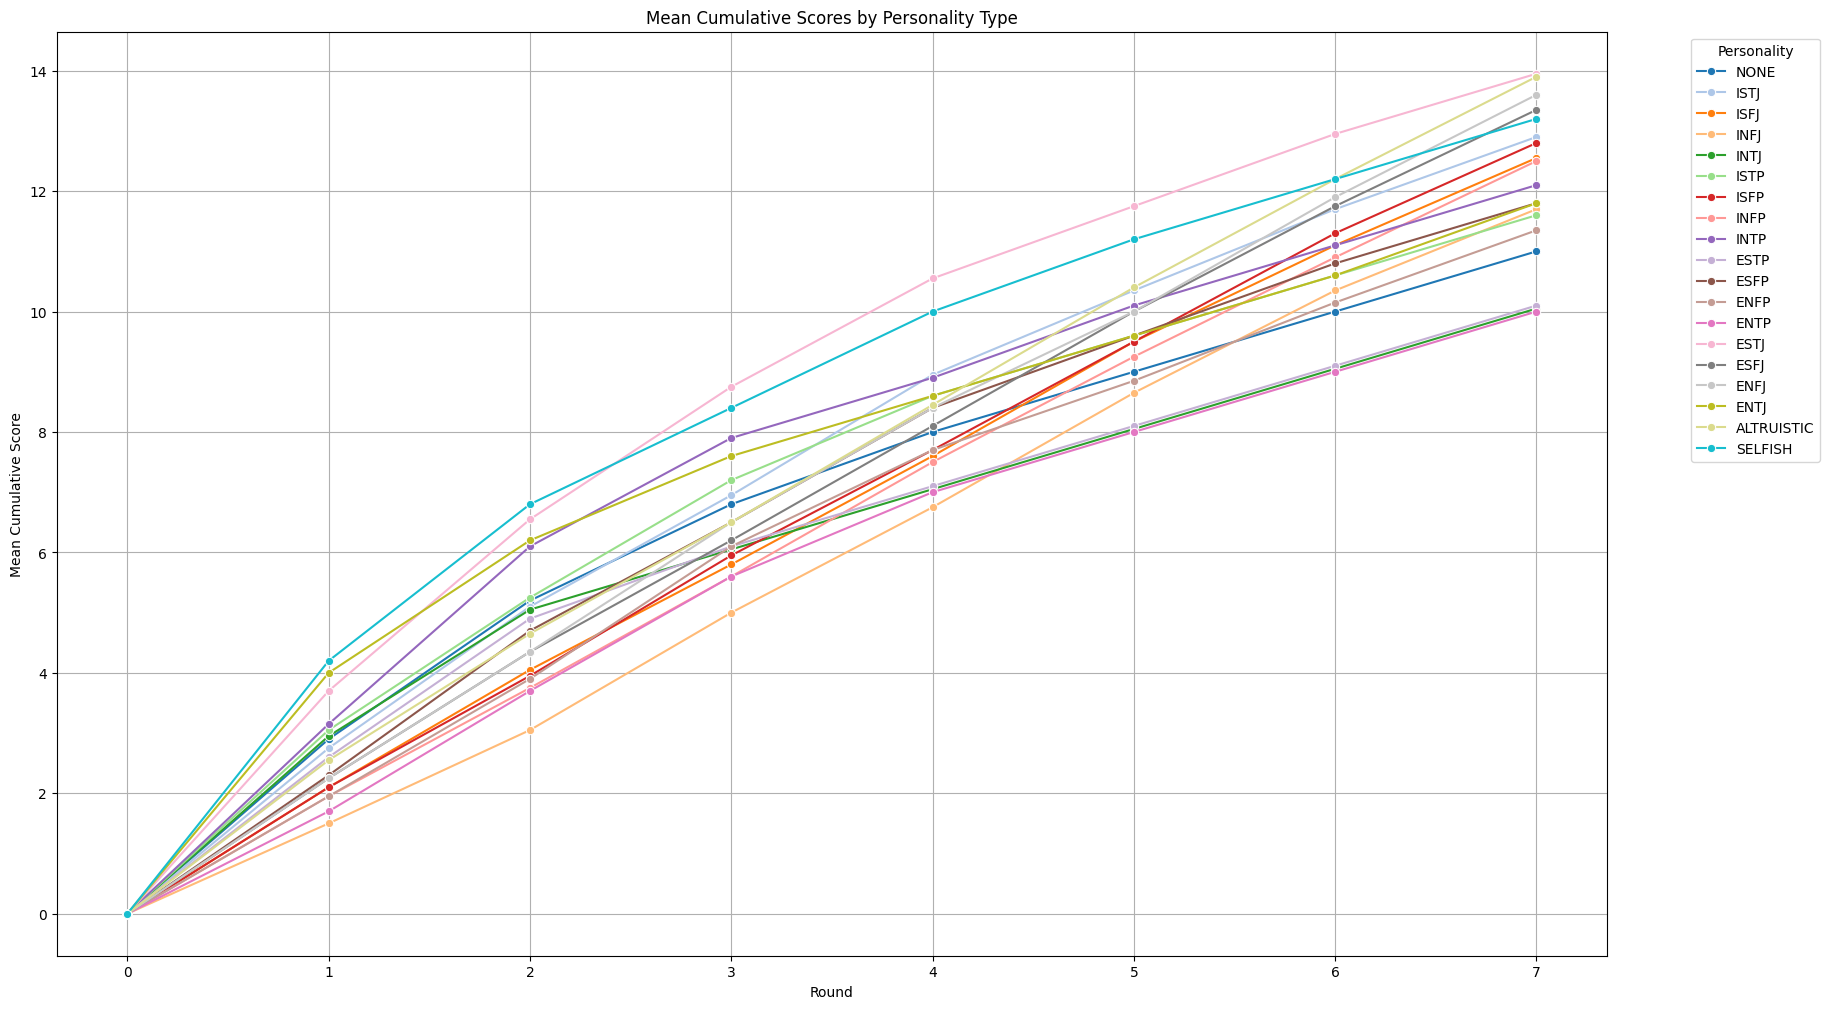

In [8]:
from collections import defaultdict

# Initialize a dictionary to store cumulative scores by personality
cumulative_scores_by_personality = defaultdict(list)

# Iterate through the dataframe and collect cumulative scores
for i, row in df.iterrows():
    for personality, scores in zip([row['personality_1'], row['personality_2']], [row['agent_1_cumulative_scores'], row['agent_2_cumulative_scores']]):
        cumulative_scores_by_personality[personality].append(scores)

# Calculate the mean cumulative scores for each personality
mean_cumulative_scores_by_personality = {}
for personality, scores_list in cumulative_scores_by_personality.items():
    # Transpose the list of scores to calculate the mean for each round
    transposed_scores = list(zip(*scores_list))
    mean_cumulative_scores = [sum(scores) / len(scores) for scores in transposed_scores]
    mean_cumulative_scores_by_personality[personality] = mean_cumulative_scores

# Print the mean cumulative scores for each personality
for personality, mean_scores in mean_cumulative_scores_by_personality.items():
    print(f"Personality: {personality}, Mean Cumulative Scores: {mean_scores}")
    
    # Create a DataFrame for plotting
    plot_data = []
    for personality, mean_scores in mean_cumulative_scores_by_personality.items():
        for round_num, score in enumerate(mean_scores):
            plot_data.append({'Personality': personality, 'Round': round_num, 'Mean Cumulative Score': score})

plot_df = pd.DataFrame(plot_data)

# Plot the mean cumulative scores for each personality
plt.figure(figsize=(20, 12))
sns.lineplot(data=plot_df, x='Round', y='Mean Cumulative Score', hue='Personality', palette='tab20', marker='o')
plt.title('Mean Cumulative Scores by Personality Type')
plt.xlabel('Round')
plt.ylabel('Mean Cumulative Score')
plt.legend(title='Personality', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

/tmp/ipykernel_3412369/1445845666.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_truthfulness, x='Personality', y='Truthfulness Percentage', palette='viridis')


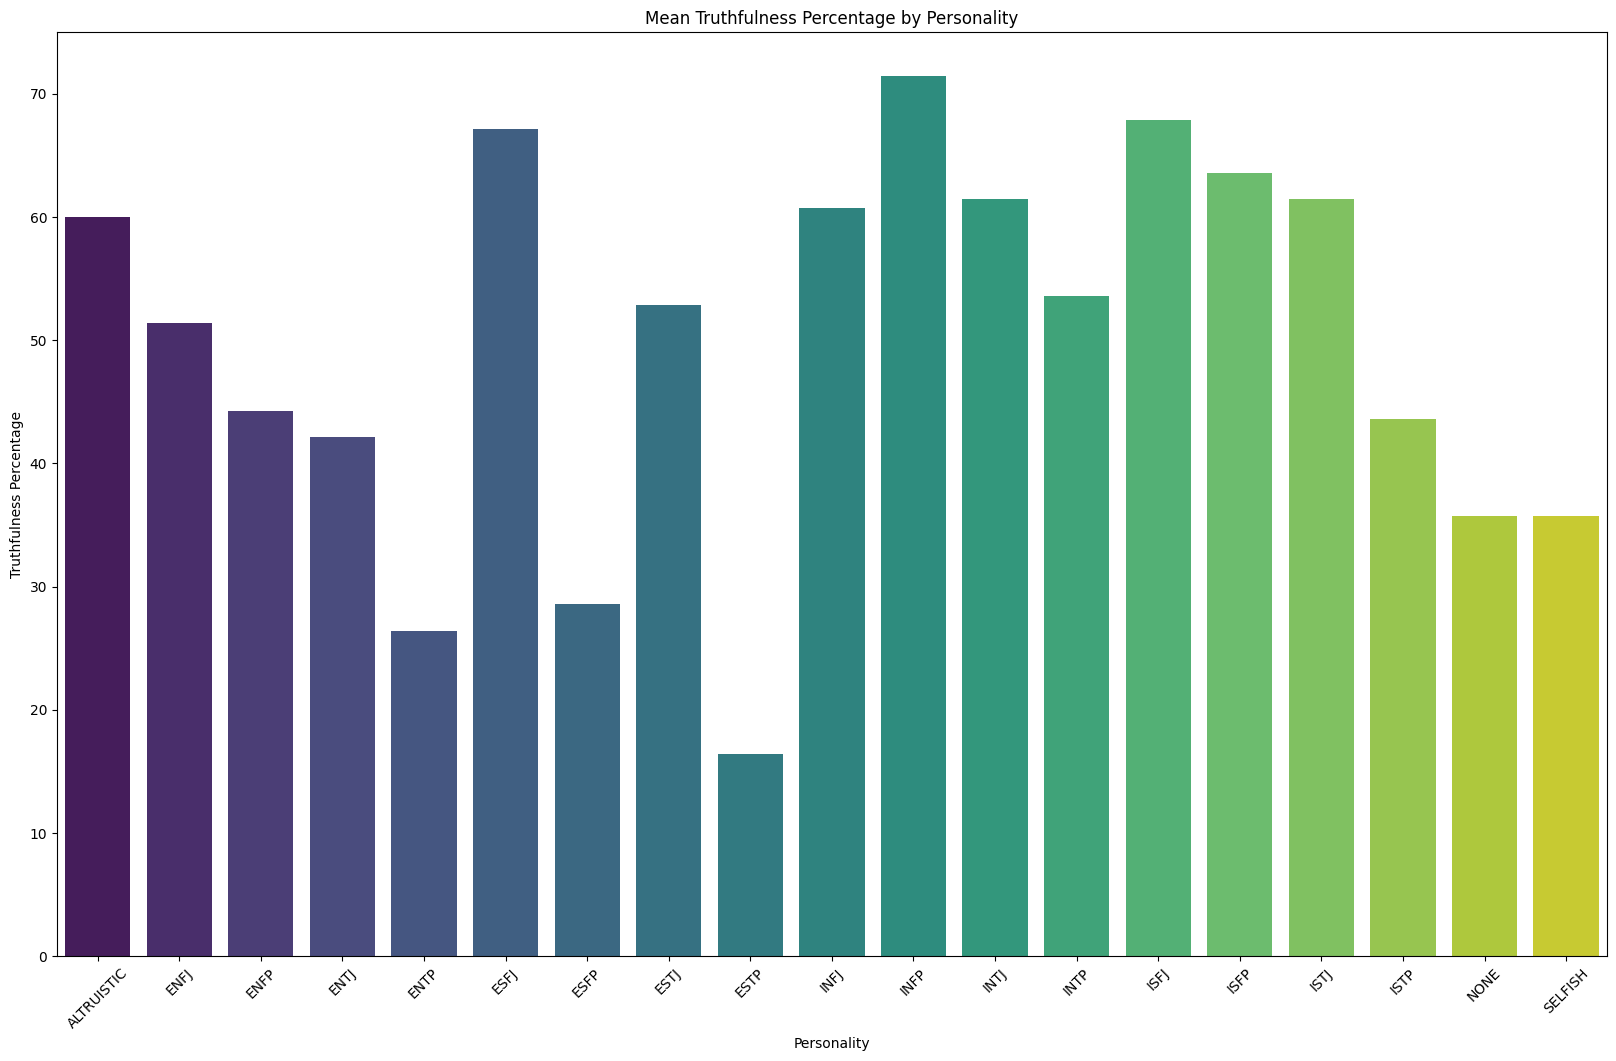

In [9]:
import ast

truthfulness_data = []

for i, row in df.iterrows():
    for personality, truthfulness in zip([row['personality_1'], row['personality_2']], [row['truthful_agent_1'], row['truthful_agent_2']]):
        try:
            truthfulness_list = ast.literal_eval(truthfulness) if isinstance(truthfulness, str) else truthfulness
            truthfulness_bool = [bool(t) for t in truthfulness_list]
            truthfulness_data.append({'Personality': personality, 'Truthful': sum(truthfulness_bool), 'Total': len(truthfulness_bool)})
        except (ValueError, SyntaxError):
            print(f"Skipping row {i} due to malformed data: {truthfulness}")

truthfulness_df = pd.DataFrame(truthfulness_data)
truthfulness_df['Truthfulness Percentage'] = truthfulness_df['Truthful'] / truthfulness_df['Total'] * 100

# Calculate the mean truthfulness percentage for each personality
mean_truthfulness = truthfulness_df.groupby('Personality')['Truthfulness Percentage'].mean().reset_index()

# Plot the mean truthfulness percentage for each personality
plt.figure(figsize=(20, 12))
sns.barplot(data=mean_truthfulness, x='Personality', y='Truthfulness Percentage', palette='viridis')
plt.title('Mean Truthfulness Percentage by Personality')
plt.xlabel('Personality')
plt.ylabel('Truthfulness Percentage')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_3412369/1688364116.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='I/E', y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ipykernel_3412369/1688364116.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='N/S', y='Truthfulness Percentage', inner='quartile', palette='Set2')
/tmp/ipykernel_3412369/1688364116.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dichotomies_df, x='T/F', y='Truthfulness Percentage', inner='quartile', palette='Set2'

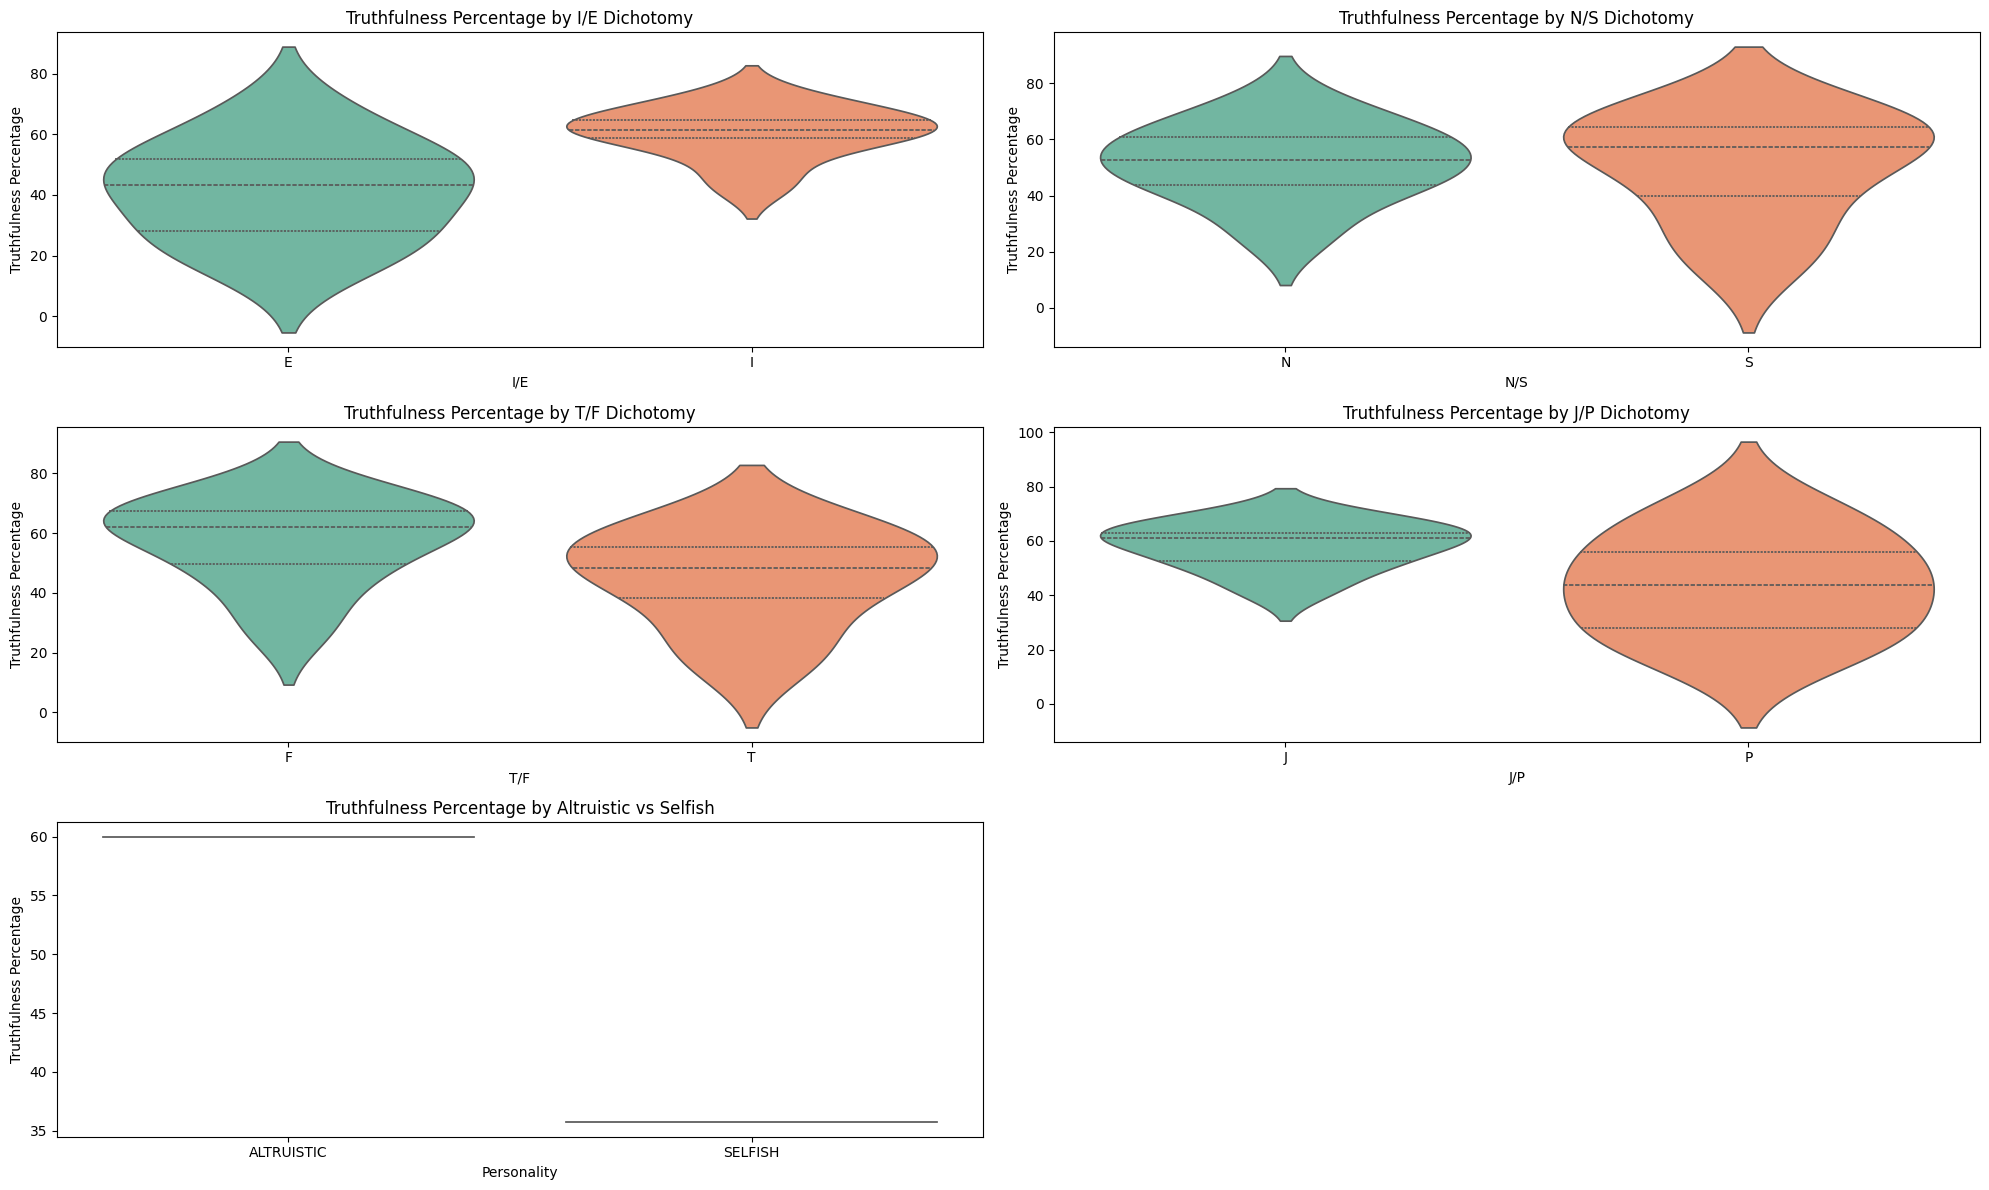

In [10]:
# Filter out the control groups
filtered_df = mean_truthfulness[~mean_truthfulness['Personality'].isin(['NONE', 'ALTRUISTIC', 'SELFISH'])]

# Create a new DataFrame to store the dichotomies
dichotomies_df = pd.DataFrame()

# Map each personality to its dichotomies
dichotomies_df['I/E'] = filtered_df['Personality'].apply(lambda x: 'I' if x[0] == 'I' else 'E')
dichotomies_df['N/S'] = filtered_df['Personality'].apply(lambda x: 'N' if x[1] == 'N' else 'S')
dichotomies_df['T/F'] = filtered_df['Personality'].apply(lambda x: 'T' if x[2] == 'T' else 'F')
dichotomies_df['J/P'] = filtered_df['Personality'].apply(lambda x: 'J' if x[3] == 'J' else 'P')
dichotomies_df['Truthfulness Percentage'] = mean_truthfulness['Truthfulness Percentage']

# Plot the boxplots for each dichotomy
plt.figure(figsize=(20, 12))

plt.subplot(3, 2, 1)
sns.violinplot(data=dichotomies_df, x='I/E', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by I/E Dichotomy')

plt.subplot(3, 2, 2)
sns.violinplot(data=dichotomies_df, x='N/S', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by N/S Dichotomy')

plt.subplot(3, 2, 3)
sns.violinplot(data=dichotomies_df, x='T/F', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by T/F Dichotomy')

plt.subplot(3, 2, 4)
sns.violinplot(data=dichotomies_df, x='J/P', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by J/P Dichotomy')

plt.subplot(3, 2, 5)
sns.violinplot(data=mean_truthfulness[mean_truthfulness['Personality'].isin(['ALTRUISTIC', 'SELFISH'])], x='Personality', y='Truthfulness Percentage', inner='quartile', palette='Set2')
plt.title('Truthfulness Percentage by Altruistic vs Selfish')

plt.tight_layout()
plt.show()

/tmp/ipykernel_3412369/1454951151.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conditional_liars_percentage, x='Personality', y='Conditional Liar Percentage', palette='magma')


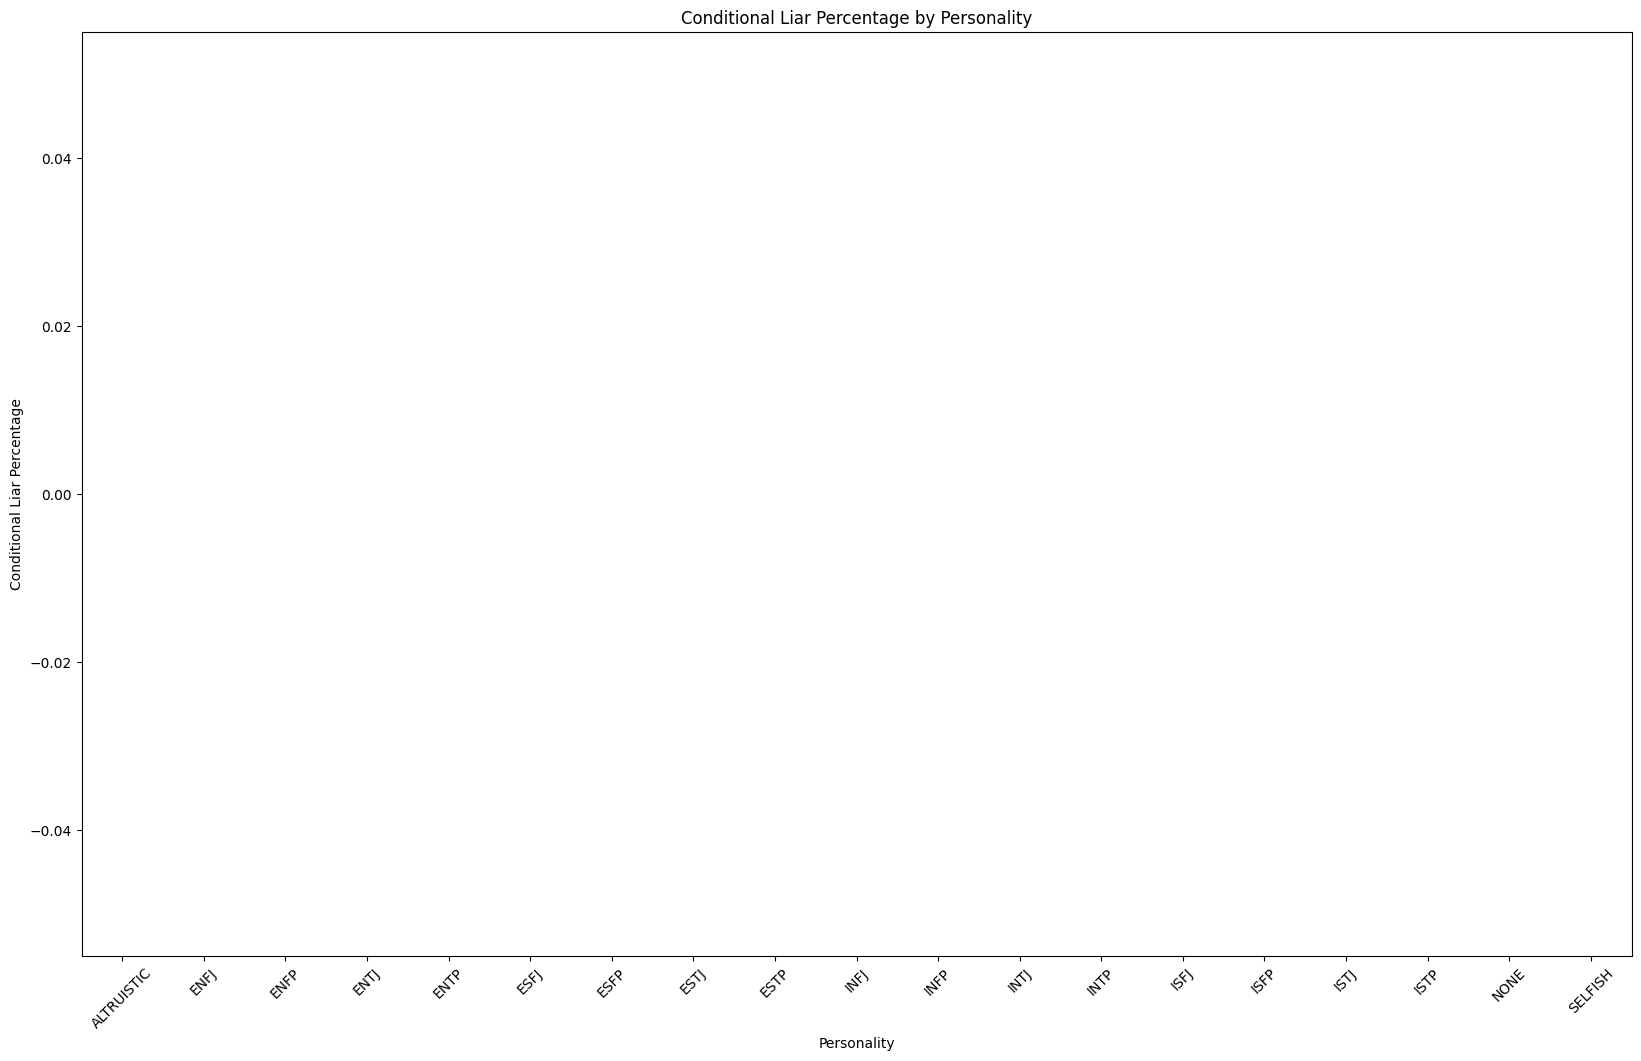

In [11]:
# Identify agents that only become liars because they got lied to
conditional_liars_data = []

for i, row in df.iterrows():
    for personality, sayingtruth, actions in zip([row['personality_1'], row['personality_2']], [row['truthful_agent_1'], row['truthful_agent_2']], [row['agent_1_actions'], row['agent_2_actions']]):
        liar_due_to_lie = False
        for j in range(1, len(sayingtruth)):
            if not sayingtruth[j] and actions[j-1] == 'defect' and sayingtruth[j-1]:
                liar_due_to_lie = True
                break
        conditional_liars_data.append({'Personality': personality, 'Conditional Liar': liar_due_to_lie})

conditional_liars_df = pd.DataFrame(conditional_liars_data)
conditional_liars_percentage = conditional_liars_df.groupby('Personality')['Conditional Liar'].mean().reset_index()
conditional_liars_percentage['Conditional Liar Percentage'] = conditional_liars_percentage['Conditional Liar'] * 100


# Plot the conditional liar percentage for each personality
plt.figure(figsize=(20, 12))
sns.barplot(data=conditional_liars_percentage, x='Personality', y='Conditional Liar Percentage', palette='magma')
plt.title('Conditional Liar Percentage by Personality')
plt.xlabel('Personality')
plt.ylabel('Conditional Liar Percentage')
plt.xticks(rotation=45)
plt.show()

In [12]:
conditional_liars_df.groupby('Personality')['Conditional Liar'].value_counts()

Personality  Conditional Liar
ALTRUISTIC   False               20
ENFJ         False               20
ENFP         False               20
ENTJ         False               20
ENTP         False               20
ESFJ         False               20
ESFP         False               20
ESTJ         False               20
ESTP         False               20
INFJ         False               20
INFP         False               20
INTJ         False               20
INTP         False               20
ISFJ         False               20
ISFP         False               20
ISTJ         False               20
ISTP         False               20
NONE         False               20
SELFISH      False               20
Name: count, dtype: int64